<a id=top-page></a>
# `pykitPIV` demo: Setup a reinforcement learning problem for a virtual particle image velocimetry (PIV) setup

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#generate-particles">Generate particles</a></li>
    <li><a href="#generate-velocity-field">Generate random velocity field to advect the particles</a></li>
    <li><a href="#add-movement">Add movement to particles</a></li>
        <ul>
        <li><a href="#add-movement-update-time-sep">Update time separation</a></li>
        <li><a href="#add-movement-visualize">Visualize the PIV image pair</a></li>
        </ul>
    <li><a href="#save">Save the dataset</a></li>
    <li><a href="#upload">Upload the saved datasets</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
from pykitPIV.ml import PIVEnv, CameraAgent, Rewards
from pykitPIV.flowfield import compute_q_criterion
from pykitPIV import ParticleSpecs, FlowFieldSpecs, MotionSpecs, ImageSpecs
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import tensorflow as tf
import torch
import sys, os
import time

2025-02-18 15:39:08.211403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare specifications for pykitPIV parameters 

Specifications can be dictionaries or objects of the appropriate configuration classes from pykitPIV.
Below, we create both examples. 

Let's start with dictionaries:

In [2]:
particle_spec = {'diameters': (1, 1),
                 'distances': (2, 2),
                 'densities': (0.4, 0.4),
                 'diameter_std': 1,
                 'seeding_mode': 'random'}

flowfield_spec = {'size': (200, 500),
                  'flowfield_type': 'random smooth',
                  'gaussian_filters': (10, 10),
                  'n_gaussian_filter_iter': 10,
                  'displacement': (2, 2)}

motion_spec = {'n_steps': 10,
               'time_separation': 1,
               'particle_loss': (0, 0),
               'particle_gain': (0, 0)}

image_spec = {'exposures': (0.98, 0.98),
              'maximum_intensity': 2**16-1,
              'laser_beam_thickness': 1,
              'laser_over_exposure': 1,
              'laser_beam_shape': 0.95,
              'alpha': 1/8,
              'clip_intensities': True,
              'normalize_intensities': False}

Otherwise, specifications can be objects of the appropriate configuration classes:

In [3]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=1,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=1,
seeding_mode='random',
random_seed=None)


In [4]:
flowfield_spec = FlowFieldSpecs(size=(200, 500),
                                flowfield_type='random smooth',
                                gaussian_filters=(10, 10),
                                n_gaussian_filter_iter=10,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 500),
size_buffer=10,
random_seed=None,
flowfield_type='random smooth',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [5]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
n_steps=10,
time_separation=1,
particle_loss=(0, 0),
particle_gain=(0, 0))


In [6]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
alpha=0.125,
clip_intensities=True,
normalize_intensities=False)


Use LIMA as an inference model:

In [7]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [8]:
model_file = '../Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

model: ../Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [9]:
lima_inference_model = ONNXmodel(model_file)

Input Name: Input


***

## Create the RL environment

Define the cues that the RL agent effectively senses and learns from:

In [10]:
def cues_function(displacement_field_tensor):

    mean_displacement = np.mean(displacement_field_tensor)
    max_displacement = np.max(displacement_field_tensor)
    min_displacement = np.min(displacement_field_tensor)
    
    cues = np.array([[mean_displacement, max_displacement, min_displacement]])

    return cues

Initialize the `Gymnasium` environment:

In [11]:
env = PIVEnv(interrogation_window_size=(100,100),
             interrogation_window_size_buffer=10,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             user_flowfield=None,
             inference_model=lima_inference_model,
             random_seed=None)

Reset the environment:

In [12]:
camera_position, cues = env.reset()

In [13]:
camera_position

array([  4, 290])

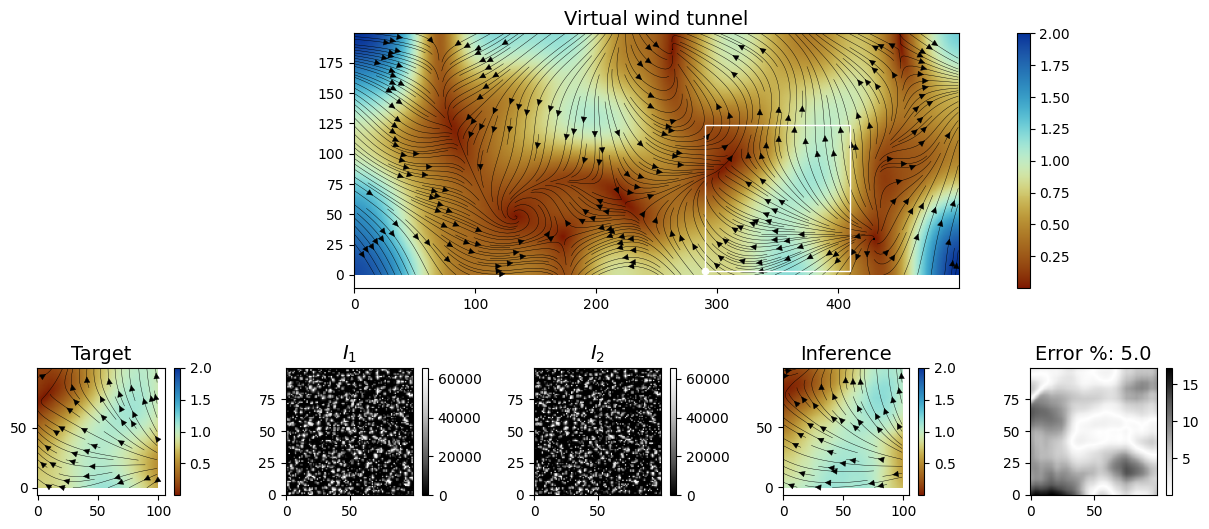

In [14]:
plt = env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(15,6), 
                 filename=None)

In [15]:
q_criterion = compute_q_criterion(env.flowfield.velocity_field, edge_order=1)

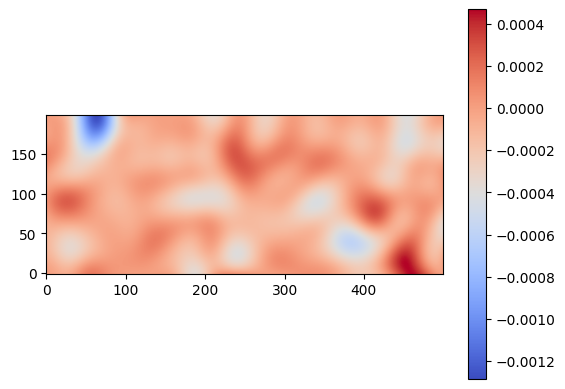

In [16]:
plt.imshow(q_criterion[0,:,:], origin='lower', cmap='coolwarm')
plt.colorbar()

Test making 10 random steps in the environment:

In [ ]:
rewards = Rewards(verbose=False)
reward_function = rewards.q_criterion

In [ ]:
def reward_transformation(Q):
    Q = np.max(Q.clip(min=0))
    return Q

In [ ]:
for _ in range(0,5):

    action = np.random.choice(5)

    print(action)
    
    camera_position, cues, reward = env.step(action, 
                                             reward_function=reward_function,
                                             reward_transformation=reward_transformation,
                                             verbose=True)

    

In [ ]:
# plt = env.render(camera_position,
#                  c='white',
#                  s=20,
#                  lw=1,
#                  normalize_cbars=True,
#                  cmap=cmc.roma,
#                  add_streamplot=True,
#                  streamplot_density=3,
#                  streamplot_color='k',
#                  streamplot_linewidth=0.3,
#                  figsize=(15,6), 
#                  filename=None)

Reset the environment with a user-defined initial camera position:

In [ ]:
camera_position, cues = env.reset(imposed_camera_position=np.array([0, 50]))

plt = env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(15,6), 
                 filename=None)

***

## Create and train an RL agent

In [ ]:
n_episodes = 10
n_iterations = 20
random_seed = 0
verbose = False
iter_count = 0
epsilon = 0.01
batch_size = 10
initial_learning_rate = 0.01
alpha_lr = 0.0001
n_epochs = 10
n_decay_steps = int(n_episodes/1.5)

Define the Q-network:

In [ ]:
class QNetwork(tf.keras.Model):
    
    def __init__(self, n_actions):
        
        super(QNetwork, self).__init__()
        
        self.dense1 = tf.keras.layers.Dense(10, activation='linear', kernel_initializer=tf.keras.initializers.Ones)
        self.dense2 = tf.keras.layers.Dense(10, activation='linear', kernel_initializer=tf.keras.initializers.Ones)
        self.output_layer = tf.keras.layers.Dense(n_actions, activation='linear', kernel_initializer=tf.keras.initializers.Ones)

    def call(self, state):
        
        x = self.dense1(state)
        x = self.dense2(x)
        
        return self.output_layer(x)

Initialize the camera agent:

In [ ]:
ca = CameraAgent(env=env,
                 target_q_network=QNetwork(env.n_actions),
                 selected_q_network=QNetwork(env.n_actions),
                 memory_size=1000,
                 batch_size=batch_size,
                 n_epochs=10,
                 learning_rate=0.001,
                 optimizer='RMSprop',
                 discount_factor=0.95)

Define the cosine learning rate decay:

In [ ]:
def decayed_learning_rate(step, initial_learning_rate, alpha, n_epochs, decay_steps):
    
    step = np.min([step, decay_steps])
    cosine_decay = 0.5 * (1 + np.cos(np.pi * step / decay_steps))
    decayed = (1 - alpha) * cosine_decay + alpha
    
    return initial_learning_rate * decayed

Initialize an object of the `Rewards` class to use one of the custom-built reward functions:

In [ ]:
rewards = Rewards(verbose=False)
reward_function = rewards.q_criterion

Define a transformation function for the reward which is appropriate to detecting vortex structures:

In [ ]:
def reward_transformation(Q):
    Q = np.max(Q.clip(min=0))
    return Q

In [ ]:
total_tic = time.perf_counter()

print('- '*50)

tic = time.perf_counter()

for episode in range(0,n_episodes):

    camera_position, cues = ca.env.reset()
    total_reward = 0
    
    # Exploration probability decreases with training time:
    # epsilon = epsilon_start/np.exp(iter_count/(500))

    for _ in range(0,n_iterations):

        action = ca.choose_action(cues,
                                  epsilon=epsilon)

        next_camera_position, next_cues, reward = ca.env.step(action,
                                                              reward_function=reward_function,
                                                              reward_transformation=reward_transformation,
                                                              verbose=False)

        ca.remember(cues,
                    action,
                    reward,
                    next_cues)
        
        cues = next_cues
        total_reward += reward

    iter_count += 1

    print('Total reward at this episode was: ' + str(total_reward))
    
    # Train the Q-network, (but holds off with training until batch_size of samples is collected):
    if len(ca.memory.buffer) >= batch_size:
    
        current_lr = decayed_learning_rate(iter_count, initial_learning_rate, alpha_lr, n_epochs, n_decay_steps)
        ca.train(current_lr)
    
        if (episode+1) % 1 == 0 :
            ca.update_target_network()

    if (episode+1) % 10 == 0:
        toc = time.perf_counter()
        print(current_lr)
        print(f"Episode: {episode + 1}, Total Reward: {total_reward:0.5f}")
        print(f'These episodes took: {(toc - tic):0.1f} sec.')
        print('- '*50)
        tic = time.perf_counter()

total_toc = time.perf_counter()
print(f'Total time: {(total_toc - total_tic)/60/60:0.2f} h.\n')

In [ ]:
MSE_losses_collected = np.array(ca.MSE_losses).ravel()

plt.figure(figsize=(20,4))
plt.semilogy(MSE_losses_collected)
# plt.ylim([0.00001,10])
plt.xlabel('Epoch #', fontsize=20)
plt.ylabel('MSE loss', fontsize=20)

***

## Test the trained agent on a new environment

In [ ]:
test_env = PIVEnv(interrogation_window_size=(100,100),
                 interrogation_window_size_buffer=10,
                 cues_function=cues_function,
                 particle_spec=particle_spec,
                 motion_spec=motion_spec,
                 image_spec=image_spec,
                 flowfield_spec=flowfield_spec,
                 user_flowfield=None,
                 inference_model=lima_inference_model,
                 random_seed=None)

Reset the environment:

In [ ]:
camera_position, cues = test_env.reset()

In [ ]:
camera_position

In [ ]:
plt = test_env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(15,6), 
                 filename=None)

***